In [ ]:
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
import errno

from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

In [ ]:
import pandas as pd

def load_data_south_indian(url):
    """
    Load and preprocess data for South Indian region.

    Parameters:
    - url (str): URL or file path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with a 'category' column.
    """
    # Load data from CSV
    df = pd.read_csv(url)

    # Add a 'category' column based on speed ranges
    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 89 else
        4 if 90 <= x <= 115 else
        5
    )

    return df

def load_data_south_pacific(url):
    """
    Load and preprocess data for South Pacific region.

    Parameters:
    - url (str): URL or file path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with a 'category' column.
    """
    # Load data from CSV
    df = pd.read_csv(url)

    # Add a 'category' column based on speed ranges
    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 85 else
        4 if 86 <= x <= 107 else
        5
    )

    return df

In [ ]:
ocean = 'south_pacific'

# Display the selected ocean
print(f"Selected ocean: {ocean}")

# Set the data URL and function based on the selected ocean
if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    data_loading_function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    data_loading_function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific'

# Display the data URL for verification
print(f"Data URL: {url_data}")

# Display the result file names
print(f"Hot-encoded result file name: {hot_encoded_result_file_name}")
print(f"Category result file name: {category_result_file_name}")

Selected ocean: south_pacific
Data URL: https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv
Hot-encoded result file name: south_pacific
Category result file name: roc_data_south_pacific


In [ ]:
# Load data using the specified function and URL
df = data_loading_function(url_data)

# Latitude and longitude values into int
df['Lat'] = df['Lat'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('N') else int(x[:-1]) * 0.1 if x.endswith('S') else 0)
df['Lon'] = df['Lon'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('W') else int(x[:-1]) * 0.1 if x.endswith('E') else 0)

# Extract 'Speed(knots)' and 'category' columns as lists
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
latitude = df['Lat'].tolist()
longitude = df['Lon'].tolist()


# Display the first few rows of the DataFrame
df_head = df.head()
print("DataFrame Head:")
print(df_head)


DataFrame Head:
  Basin  No. of Cycl        Time     V5  V6   Lat    Lon  Speed(knots)  \
0    SP           14  1982012518   BEST   0  18.0  154.1            25   
1    SP           14  1982012600   BEST   0  19.1  154.8            25   
2    SP           14  1982012606   BEST   0  19.7  155.7            25   
3    SP           14  1982012612   BEST   0  19.9  156.7            30   
4    SP           14  1982012618   BEST   0  20.1  157.8            35   

   lat_tenth  lon_tenth  category  
0       18.0      154.1         0  
1       19.1      154.8         0  
2       19.7      155.7         0  
3       19.9      156.7         0  
4       20.1      157.8         1  


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def split_sequence(sequences, n_steps_in, n_steps_out):
    """
    Split multivariate sequences into input and output parts.

    Parameters:
    - sequences (numpy.ndarray): Multivariate time series data.
    - n_steps_in (int): Number of input time steps.
    - n_steps_out (int): Number of output time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def uni_split_sequence(sequence, n_steps):
    """
    Split univariate sequence into input and output parts.

    Parameters:
    - sequence (list): Univariate time series data.
    - n_steps (int): Number of input time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def multivariate_split_sequence(sequence, n_steps):
    """
    Split multivariate sequence into input and output parts.

    Parameters:
    - sequence (numpy.ndarray): Multivariate time series data.
    - n_steps (int): Number of input time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Example usage:
# Assuming df is your DataFrame with 'Latitude', 'Longitude', 'Speed(knots)', and 'category' columns
features_columns = ['Lat', 'Lon']
target_column = 'category'

# Extract features and target
features = df[features_columns].values
target = df[target_column].values

n_steps = 5  # Number of input time steps

X, y = multivariate_split_sequence(features, n_steps)

# Now X contains sequences of 'Latitude', 'Longitude', and 'Speed(knots)' for each time step,
# and y contains the corresponding 'category' values.

def rmse(pred, actual):
    """
    Calculate the Root Mean Squared Error (RMSE) between two arrays.

    Parameters:
    - pred (numpy.ndarray): Predicted values.
    - actual (numpy.ndarray): Actual values.

    Returns:
    - float: Root Mean Squared Error.
    """
    return np.sqrt(((pred - actual) ** 2).mean())

def categorical(pred, actual):
    """
    Compute classification metrics for categorical values.

    Parameters:
    - pred (numpy.ndarray): Predicted categorical values.
    - actual (numpy.ndarray): Actual categorical values.

    Returns:
    - tuple: Accuracy, AUC, Confusion Matrix, Precision, Recall, F1 Score.
    """
    cm = confusion_matrix(pred, actual)
    acc = accuracy_score(actual, pred, normalize=True, sample_weight=None)
    ps1 = precision_score(pred, actual, average='micro')
    rs1 = recall_score(pred, actual, average='micro')
    f11 = f1_score(pred, actual, average='micro')
    auc = roc_auc_score(actual, pred)
    return acc, auc, cm, ps1, rs1, f11

def make_confusion_matrix_chart(cf_matrix_test, cmap='Blues', annot_kws=None):
    """
    Generate and display a heatmap-style confusion matrix chart.

    Parameters:
    - cf_matrix_test (numpy.ndarray): Confusion matrix.
    - cmap (str): Colormap for the heatmap.
    - annot_kws (dict): Additional keyword arguments for annotation customization.

    Returns:
    - None
    """
    # Set up the figure and axes
    plt.figure(figsize=(12, 6))

    # Customize the heatmap using seaborn
    sns.heatmap(cf_matrix_test, annot=True, cmap=cmap,
                yticklabels=['0', '1'], xticklabels=['0', '1'],
                fmt='g', annot_kws=annot_kws)

    # Customize axis labels and title
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix - Test Data')

    return None


In [ ]:
# Define whether it's a univariate or multivariate case
univariate_1 = False  # If True, it's a multivariate case

# Define sequence and time step parameters
n_steps_in_1 = 6 # Adjust based on the number of time steps you want to consider for input
n_seq_1= 2  # Adjust based on your specific needs
n_steps_out_1 = 1  # Number of output time steps

# Define the number of features for input and output
n_features_in_1 = 2  # Latitude, Longitude
n_features_out_1 = 2  # 'category'

# Define whether it's a univariate or multivariate case
univariate_2 = True  # If not True, it's a multivariate case

# Define sequence and time step parameters
n_steps_in_2  = 8  # Adjust based on the number of time steps you want to consider for input
n_seq_2 = 2  # Adjust based on your specific needs
n_steps_out_2 = 1  # Number of output time steps

# Define the number of features for input and output
n_features_in_2 = 1  # Latitude, Longitude, Speed
n_features_out_2 = 2  # 'category'

# Define the number of hidden layers in the model
hidden_layers = 50

# Define training parameters
epochs = 100
No_exp = 30 # Number of experiments

# Display the configuration


In [ ]:
# Initialize variables
cyclone_id = df['No. of Cycl'][0]
X1= []
Y1 = []
start_index = 0
end_index = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index += 1
    else:
        # Split the sequence and append to X and Y
        x, y = multivariate_split_sequence(features[start_index:end_index + 1, :], n_steps_in_1)
        X1.append(x)
        Y1.append(y)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index = i
        end_index = i

    # Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X and Y
        x, y = multivariate_split_sequence(features[start_index:end_index + 1, :], n_steps_in_1)
        X1.append(x)
        Y1.append(y)


In [ ]:
# Print the initial lengths of X and Y
print("Initial Lengths - X:", len(X1), "Y:", len(Y1))

# Flattening X and Y
X1 = [item for sublist in X1 for item in sublist]
Y1 = [item for sublist in Y1 for item in sublist]

# Print lengths of X and Y after flattening
print("Flattened Lengths - X:", len(X1), "Y:", len(Y1))

# Print some initial values from X and Y
print(Y1[0])

# Print some initial values from the 'speed' column


Initial Lengths - X: 391 Y: 391
Flattened Lengths - X: 9697 Y: 9697
159.10000000000002


In [ ]:
# Initialize variables
cyclone_id = df['No. of Cycl'][0]
X = []
Y = []
start_index = 0
end_index = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index += 1
    else:
        # Split the sequence and append to X and Y
        x, y = uni_split_sequence(speed[start_index:end_index + 1], n_steps_in_1)
        X.append(x)
        Y.append(y)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index = i
        end_index = i

    # Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X and Y
        x, y = uni_split_sequence(speed[start_index:end_index + 1], n_steps_in_1)
        X.append(x)
        Y.append(y)

In [ ]:
# Print the initial lengths of X and Y
print(len(X), len(Y))
# Flattening X and Y
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
# Print lengths of X and Y after flattening
print(len(X), len(Y))
print(type(X), Y[0])
print(speed[:10])


391 391
9697 9697
<class 'list'> 40
[25, 25, 25, 30, 35, 40, 40, 40, 40, 40]


18863


In [ ]:

# Initialize 'intensify_y' with zeros
intensify_y = [0] * len(X)

# Iterate through each row in X and update intensify_y based on the condition
for i in range(len(X)):
    for j in range(len(X[0]) - 4, len(X[0])):
        if (Y[i] - X[i][j]) >= 30:
            intensify_y[i] = 1
            break

print(len(intensify_y))

# Use 'intensify_y' as the updated target variable
Y = intensify_y
Y1 = Y


9697


In [ ]:
# Calculate the training limit as 75% of the total length of X
train_limit = int(len(X) * 0.75)

# Display the calculated training limit
print("Training set size:", train_limit)

Training set size: 7272


In [ ]:
print(X1[0], X[0])

[[ 18.  154.1]
 [ 19.1 154.8]
 [ 19.7 155.7]
 [ 19.9 156.7]
 [ 20.1 157.8]
 [ 20.4 158.6]] [25 25 25 30 35 40]


In [ ]:
# Extract test data for evaluation
test_X_original_1 = X1[train_limit + 1:]
test_Y_original_1 = Y1[train_limit + 1:]

# Display the lengths of the datasets
print("Length of X:", len(X1))
print("Length of Y:", len(Y1))
print("Length of Test X (for evaluation):", (test_X_original_1[0]))
print("Length of Test Y (for evaluation):", (test_Y_original_1[0]))

# Extract test data for evaluation
test_X_original = X[train_limit + 1:]
test_Y_original = Y[train_limit + 1:]

# Display the lengths of the datasets
print("Length of X:", len(X))
print("Length of Y:", len(Y))
print("Length of Test X (for evaluation):", test_X_original)
print("Length of Test Y (for evaluation):", test_Y_original)

Length of X: 9697
Length of Y: 9697
Length of Test X (for evaluation): [[  13.7 -171.6]
 [  13.4 -171.7]
 [  13.4 -171.7]
 [  13.4 -171.7]
 [  13.  -171.9]
 [  13.  -171.9]]
Length of Test Y (for evaluation): 0
Length of X: 9697
Length of Y: 9697
Length of Test X (for evaluation): [array([ 90,  90,  90,  90, 100, 100]), array([ 90,  90,  90, 100, 100, 100]), array([ 90,  90, 100, 100, 100, 100]), array([ 90, 100, 100, 100, 100, 100]), array([100, 100, 100, 100, 100, 100]), array([100, 100, 100, 100, 100, 100]), array([100, 100, 100, 100, 100, 100]), array([100, 100, 100, 100, 100, 100]), array([100, 100, 100, 100, 100,  95]), array([100, 100, 100, 100,  95,  95]), array([100, 100, 100,  95,  95,  95]), array([100, 100,  95,  95,  95,  90]), array([100,  95,  95,  95,  90,  90]), array([95, 95, 95, 90, 90, 90]), array([95, 95, 90, 90, 90, 90]), array([95, 90, 90, 90, 90, 90]), array([90, 90, 90, 90, 90, 90]), array([90, 90, 90, 90, 90, 90]), array([90, 90, 90, 90, 90, 90]), array([90, 9

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X1 = np.array(X1)
scalers = {}
for i in range(X1.shape[1]):
    scalers[i] = MinMaxScaler()
    X1[:, i, :] = scalers[i].fit_transform(X1[:, i, :])
print(X1[0])

[[0.39892183 0.92805556]
 [0.40526316 0.93      ]
 [0.40458015 0.9325    ]
 [0.3955774  0.93527778]
 [0.38625592 0.93833333]
 [0.37813212 0.94055556]]


In [ ]:
# Normalize the sequences in X using Min-Max scaling
X = MinMaxScaler().fit_transform(np.asarray(X))
print(X)

[[0.07142857 0.07142857 0.07142857 0.10714286 0.14285714 0.17857143]
 [0.07142857 0.07142857 0.10714286 0.14285714 0.17857143 0.17857143]
 [0.07142857 0.10714286 0.14285714 0.17857143 0.17857143 0.17857143]
 ...
 [0.14285714 0.10714286 0.07142857 0.07142857 0.07142857 0.07142857]
 [0.10714286 0.07142857 0.07142857 0.07142857 0.07142857 0.03571429]
 [0.07142857 0.07142857 0.07142857 0.07142857 0.03571429 0.03571429]]


In [ ]:
speed_x = X1
test_X_1 = X1[train_limit+1:]
test_X_1 = np.asarray(test_X_1).astype(float)
test_Y_1 = Y1[train_limit+1:]
X1 = X1[:train_limit]
X1 = np.asarray(X1).astype(float)
Y1 = Y1[:train_limit]
print(test_Y_1)
c = 0
for i in test_Y_1:
  if(i==1):
    c = c+1

print(c)


len(X1), len(Y1)




# Similarly, you can do the same for the training set (X and Y) before splitting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

(7272, 7272)

In [ ]:
speed_x = X
test_X = X[train_limit+1:]
test_X = np.asarray(test_X).astype(float)
test_Y = Y[train_limit+1:]
X = X[:train_limit]
X = np.asarray(X).astype(float)
Y = Y[:train_limit]
print(test_Y)
c = 0
for i in test_Y:
  if(i==1):
    c = c+1

print(c)
len(X), len(Y)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

(7272, 7272)

In [ ]:
c = 0
for i in Y1:
  if(i==1):
    c = c+1

print(c)

375


In [ ]:
# Calculate the class distribution for training and test data
counter_train_1 = Counter(Y1)
counter_test_1 = Counter(test_Y_1)

# Display the class distribution for training data
print("Class Distribution - Training Data:")
print(counter_train_1)

# Display the class distribution for test data
print("\nClass Distribution - Test Data:")
print(counter_test_1)

Class Distribution - Training Data:
Counter({0: 6897, 1: 375})

Class Distribution - Test Data:
Counter({0: 2396, 1: 28})


In [ ]:
import matplotlib.pyplot as plt

# Assuming counter_train is already defined

# Set
plt.style.use('seaborn-darkgrid')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,5))

# Bar plot with red bars
bars = plt.bar(range(len(counter_train_1)), list(counter_train_1.values()), color='lightcoral', edgecolor='black', align='center')

# Customizing individual bars
for bar in bars:
    yvar = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yvar + 50, round(yvar, 2), ha='center', va='bottom', fontsize=12, color='#2E4053')

# X-axis and Y-axis labels
plt.xlabel('Category', size=16, labelpad=15)
plt.ylabel('Number of cyclones', size=16, labelpad=15)

# Title
plt.title('Majority and Minority class distribution in Training Data', size=20, pad=20)

# Tick parameters with only '0' and '1' on the x-axis
plt.xticks(range(2), ['0', '1'], fontsize=12)

# Tick parameters for y-axis
ax.tick_params(axis='y', which='major', labelsize=12)

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save figure
plt.savefig('class_distribution_red.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()




OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate

def stacked_lstm(n_steps_in_1, n_features_in_1, n_steps_in_2, n_features_in_2):
    input_1 = Input(shape=(n_steps_in_1, n_features_in_1))
    lstm_1 = LSTM(50, activation='relu')(input_1)

    input_2 = Input(shape=(n_steps_in_2, n_features_in_2))
    lstm_2 = LSTM(50, activation='relu')(input_2)

    concat = concatenate([lstm_1, lstm_2])
    output = Dense(2, activation='softmax')(concat)

    model = Model(inputs=[input_1, input_2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import time

def lstm(x_train, x_train_1, y_train, x_test_1, x_test, y_test, Num_Exp, n_steps_in_1, n_steps_in_2, n_steps_out_1, n_steps_out_2, n_features_in_1, n_features_in_2, n_features_out_1, n_features_out_2, Epochs, hidden_layers):
    # Initialize arrays to store accuracy metrics
    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)

    stacked_model = stacked_lstm(6, 2, 6, 1)
    stacked_model.summary()
    # Initialize arrays to store predictions and classification reports

    y_predicttest_allruns = np.zeros([Num_Exp, x_test.shape[0], y_test.shape[1]])
    Best_f1 = 0  # Initialize the best F1 score
    Best_Predict_Test = 0

    # Extract the actual classes from one-hot encoded vectors for both test and train sets
    act_test = [y_test[i].argmax() for i in range(y_test.shape[0])]
    act_train = [y_train[i].argmax() for i in range(y_train.shape[0])]

    # Initialize dictionaries to store classification reports
    Best_report_train = dict()
    Best_report_test = dict()
    all_report_train = dict()
    all_report_test = dict()

    # Loop through experiment runs
    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")

        # Fit the stacked model

        stacked_model.fit([x_train_1, x_train], y_train, epochs=Epochs, batch_size=10, verbose=0, shuffle=False)
        y_predicttrain = stacked_model.predict([x_train_1, x_train])
        y_predicttest = stacked_model.predict([x_test_1, x_test])
        print(y_predicttrain[0])
        print(y_predicttest[0])

        # Extract predicted classes from one-hot encoded vectors
        pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
        pred_train = [y_predicttrain[i].argmax() for i in range(y_predicttrain.shape[0])]

        c = 0
        for i in pred_test:
           if i==1:
             c = c+1

        print(c)
        d = 0
        for i in pred_train:
           if i==1:
             d = d+1

        print(d)

        # Generate classification reports
        report_train = classification_report(act_train, pred_train, labels=[0, 1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0, 1], output_dict=True)

        # Store classification reports in dictionaries
        all_report_train[run] = report_train
        all_report_test[run] = report_test

        # Calculate F1-score for the test set
        test_acc[run] = report_test['1']['f1-score']
        print("train acc: ", report_train['1']['f1-score'])
        print("test acc: ", test_acc[run])

    # Update the best F1 score and associated predictions and reports
    if test_acc[run] > Best_f1:
        Best_f1 = test_acc[run]
        Best_Predict_Test = y_predicttest
        Best_report_train, Best_report_test = report_train, report_test

    # Save the trained model (assuming you have the 'ocean' variable)
    stacked_model.save("model_" + ocean + "_stacked_lstm.h5")

    # Calculate standard deviations of train and test accuracies
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)

    # Display experiment summary
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("F1 scores for test data: ", test_acc)
    print("Mean: ", np.mean(test_acc), "Std Dev: ", test_std)

    # Return relevant information
    return train_acc, test_acc, train_std, test_std, Best_Predict_Test, y_predicttrain, y_predicttest, all_report_train, all_report_test


In [ ]:
# Create a random permutation of indices for shuffling
# idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X))
print(len(idx))

# Initialize lists to store shuffled data
x_shuffled = []
y_shuffled = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    # x_shuffled.append(X_smote[i])
    # y_shuffled.append(Y_smote[i])
    x_shuffled.append(X[i])
    y_shuffled.append(Y[i])

7272


In [ ]:
# Create a random permutation of indices for shuffling
# idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X1))
print(len(idx))

# Initialize lists to store shuffled data
x_shuffled_1 = []
y_shuffled_1  = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    # x_shuffled.append(X_smote[i])
    # y_shuffled.append(Y_smote[i])
    x_shuffled_1.append(X1[i])
    y_shuffled_1.append(Y1[i])

7272


In [ ]:
# Convert the shuffled labels to one-hot encoded format for training data
Y_hot_encoded_train = np.asarray(to_categorical(y_shuffled))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test = np.asarray(to_categorical(test_Y))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)


(7272, 2) (2424, 2)


In [ ]:
# Convert the shuffled labels to one-hot encoded format for training data
Y_hot_encoded_train_1 = np.asarray(to_categorical(y_shuffled_1))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test_1 = np.asarray(to_categorical(test_Y_1))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train_1.shape, Y_hot_encoded_test_1.shape)

(7272, 2) (2424, 2)


In [ ]:
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()

In [ ]:
# Loop over different values of n_steps_out (in this case, only 1)
for j in range(1):
    # Initialize dictionaries to store results for the ensemble model
    predictions_train_per_step = dict()
    actual_train_per_step = dict()
    predictions_test_per_step = dict()
    actual_test_per_step = dict()
    metrics_train_per_step = dict()
    metrics_test_per_step = dict()
    test_acc_per_step = dict()
    test_stddev_per_step = dict()
    n_steps_out = j + 1

    print('---------------------------------------------------------')
    print('Number of steps out:', n_steps_out)

    # Reshape data based on the ensemble model type
    x_train_1, y_train_1 = np.asarray(x_shuffled_1), np.asarray(Y_hot_encoded_train_1)
    x_test_1, y_test_1 = np.asarray(test_X_1), np.asarray(Y_hot_encoded_test_1)

    x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
    x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)

    # Call ensemble_lstm to create the ensemble model


    # Call the lstm function with the ensemble model and retrieve results
    train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = lstm(x_train, x_train_1, y_train, x_test_1, x_test,  y_test, No_exp, n_steps_in_1, n_steps_in_2, n_steps_out_1, n_steps_out_2, n_features_in_1, n_features_in_2, n_features_out_1, n_features_out_2, epochs, hidden_layers)
    # Store results in respective dictionaries
    predictions_train_per_step['ensemble'] = Best_Predict_Test
    actual_train_per_step['ensemble'] = y_train
    predictions_test_per_step['ensemble'] = Best_Predict_Test
    actual_test_per_step['ensemble'] = y_test
    metrics_train_per_step['ensemble'] = report_train
    metrics_test_per_step['ensemble'] = report_test
    test_acc_per_step['ensemble'] = test_acc
    test_stddev_per_step['ensemble'] = test_std_dev

    # Store results for the current n_steps_out in the overall dictionaries
    predictions_train[str(j + 1)] = predictions_train_per_step
    actual_train[str(j + 1)] = actual_train_per_step
    predictions_test[str(j + 1)] = predictions_test_per_step
    actual_test[str(j + 1)] = actual_test_per_step
    metrics_train[str(j + 1)] = metrics_train_per_step
    metrics_test[str(j + 1)] = metrics_test_per_step
    test_acc_all[str(j + 1)] = test_acc_per_step
    test_stddev[str(j + 1)] = test_stddev_per_step


---------------------------------------------------------
Number of steps out: 1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 6, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 50)             │         10,600 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 50)             │         10,400 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100)            │              0 │ lstm_2[0][0],          │
│ (Concatenate)             │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            202 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,202 (82.82 KB)

 Trainable params: 21,202 (82.82 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1 in progress
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[9.9999994e-01 7.2078126e-09]
[9.999923e-01 7.679951e-06]
19
264
train acc:  0.7511737089201878
test acc:  0.3829787234042553
Experiment 2 in progress
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[9.9999994e-01 1.4343472e-08]
[9.9998277e-01 1.7147919e-05]
18
291
train acc:  0.7867867867867868
test acc:  0.43478260869565216
Experiment 3 in progress
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[9.9999994e-01 2.8681293e-10]
[9.9999994e-01 2.9804010e-08]
15
286
train acc:  0.8048411497730711
test acc:  0.4186046511627907
Experiment 4 in progress
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[9.9999994e-01 7.0908035e-20]
[9.9999994e-01 2.2535458e-09]
20
275
train acc:  0.8
test acc:  0.4166666666666667
Experiment 5 in progress
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
76/76 ━━━━━━━━━━━━

train acc:  0.9504132231404959
test acc:  0.3333333333333333
Total time for 30 experiments 13031.604271888733
F1 scores for test data:  [0.38297872 0.43478261 0.41860465 0.41666667 0.4        0.38596491
 0.36363636 0.30769231 0.32727273 0.39285714 0.42424242 0.36734694
 0.35714286 0.3880597  0.33333333 0.39344262 0.33898305 0.31034483
 0.41935484 0.33846154 0.27777778 0.36363636 0.35483871 0.27586207
 0.44117647 0.34285714 0.36111111 0.45070423 0.3030303  0.33333333]
Mean:  0.3668498581180095 Std Dev:  0.046612287613181355


In [ ]:
with open("predictions_" + ocean + '_original' + '.pkl', 'wb') as f:
    pickle.dump([predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test,test_acc,test_stddev], f)


In [ ]:
def make_confusion_matrix_chart(cf_matrix, name):
    """
    Create and save a well-formatted confusion matrix heatmap.

    Parameters:
    - cf_matrix: Confusion matrix
    - name: Name of the file to save the plot

    Returns:
    - None
    """

    # Set a Seaborn style with dark grid
    sns.set(style="darkgrid", font_scale=1.5)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Customize the appearance of the heatmap with green colors
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens',
                linewidths=.5, square=True, cbar=False,
                annot_kws={"size": 16}, ax=ax)

    # Set labels and title
    plt.ylabel("Actual", size=18)
    plt.xlabel("Predicted", size=18)
    plt.title("Confusion Matrix", size=20)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Save the plot as an image
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')

    # Display the plot
    plt.show()

    # Return None
    return None




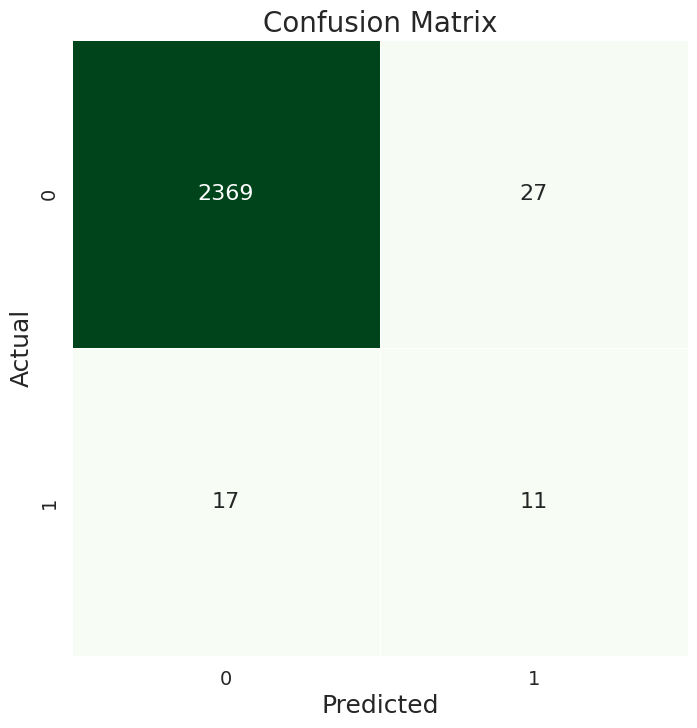

In [ ]:
y = [i.argmax() for i in actual_test_per_step['ensemble']]
pred = [i.argmax() for i in predictions_test_per_step['ensemble']]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart(cf_matrix_test, ocean + '_ensemble_cm_original')

In [ ]:
# Initialize lists to store precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
# macro average, and weighted average across multiple experiments
precision0 = []
precision1 = []
precisionacc = []
precisionmacavg = []
precisionweighavg = []
recall0 = []
recall1 = []
recallacc = []
recallmacavg = []
recallweighavg = []
f10 = []
f11 = []
f1acc = []
f1macavg = []
f1weighavg = []

# Loop through the results of multiple experiments
for i in range(No_exp):
    # Append precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
    # macro average, and weighted average from the 'vanilla' model results
    precision0.append(metrics_test_per_step['ensemble'][i]['0']['precision'])
    precision1.append(metrics_test_per_step['ensemble'][i]['1']['precision'])
    precisionacc.append(metrics_test_per_step['ensemble'][i]['accuracy'])
    precisionmacavg.append(metrics_test_per_step['ensemble'][i]['macro avg']['precision'])
    precisionweighavg.append(metrics_test_per_step['ensemble'][i]['weighted avg']['precision'])

    recall0.append(metrics_test_per_step['ensemble'][i]['0']['recall'])
    recall1.append(metrics_test_per_step['ensemble'][i]['1']['recall'])
    recallacc.append(metrics_test_per_step['ensemble'][i]['accuracy'])
    recallmacavg.append(metrics_test_per_step['ensemble'][i]['macro avg']['recall'])
    recallweighavg.append(metrics_test_per_step['ensemble'][i]['weighted avg']['recall'])

    f10.append(metrics_test_per_step['ensemble'][i]['0']['f1-score'])
    f11.append(metrics_test_per_step['ensemble'][i]['1']['f1-score'])
    f1acc.append(metrics_test_per_step['ensemble'][i]['accuracy'])
    f1macavg.append(metrics_test_per_step['ensemble'][i]['macro avg']['f1-score'])
    f1weighavg.append(metrics_test_per_step['ensemble'][i]['weighted avg']['f1-score'])


In [ ]:
print(str(round(np.mean(precision0),4)) + "±" + str(round(np.std(precision0),4))," & " + str(round(np.mean(recall0),4)) + "±" + str(round(np.std(recall0),4)), " & " + str(round(np.mean(f10),4)) + "±" + str(round(np.std(f10),4)))
print(str(round(np.mean(precision1),4)) + "±" + str(round(np.std(precision1),4))," & " + str(round(np.mean(recall1),4)) + "±" + str(round(np.std(recall1),4)), " & " + str(round(np.mean(f11),4)) + "±" + str(round(np.std(f11),4)))
print(str(round(np.mean(precisionacc),4)) + "±" + str(round(np.std(precisionacc),4))," & " + str(round(np.mean(recallacc),4)) + "±" + str(round(np.std(recallacc),4)), " & " + str(round(np.mean(f1acc),4)) + "±" + str(round(np.std(f1acc),4)))
print(str(round(np.mean(precisionmacavg),4)) + "±" + str(round(np.std(precisionmacavg),4))," & " + str(round(np.mean(recallmacavg),4)) + "±" + str(round(np.std(recallmacavg),4)), " & " + str(round(np.mean(f1macavg),4)) + "±" + str(round(np.std(f1macavg),4)))
print(str(round(np.mean(precisionweighavg),4)) + "±" + str(round(np.std(precisionweighavg),4))," & " + str(round(np.mean(recallweighavg),4)) + "±" + str(round(np.std(recallweighavg),4)), " & " + str(round(np.mean(f1weighavg),4)) + "±" + str(round(np.std(f1weighavg),4)))



0.9928±0.0008  & 0.9915±0.003  & 0.9922±0.0014
0.3668±0.0875  & 0.3857±0.0711  & 0.3668±0.0466
0.9845±0.0027  & 0.9845±0.0027  & 0.9845±0.0027
0.6798±0.0437  & 0.6886±0.0347  & 0.6795±0.0237
0.9856±0.0012  & 0.9845±0.0027  & 0.985±0.0017
